In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cf
import cfplot as cfp
import xclim
import pandas as pd
import netCDF4

from nc_processing import *
from analysis import * 

%matplotlib inline

Redefining 'delta_degC' (<class 'pint.definitions.UnitDefinition'>)
Redefining 'Δcelsius' (<class 'pint.definitions.UnitDefinition'>)
Redefining 'degC' (<class 'pint.definitions.UnitDefinition'>)
Redefining 'celsius' (<class 'pint.definitions.UnitDefinition'>)
Redefining 'C' (<class 'pint.definitions.UnitDefinition'>)
Redefining 'd' (<class 'pint.definitions.UnitDefinition'>)
/home/users/pjirvine/.conda/envs/climate_39/lib/python3.9/site-packages/xarray/core/options.py:67: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(



In [2]:
"""
Specify the common inputs
"""
data_dir='/home/users/pjirvine/data/' # !!!!!!!!!!!!! CHANGE THIS !!!!!!!!!!!!!!!!!!

model='UKESM1-0-LL'
centre='MOHC'

var='tas'
domain='day'

grid='gn'
time_files=1

# specify a list of runs
runs=['r1i1p1f2','r4i1p1f2','r8i1p1f2']

index_name = 'growing_degree_days'

# specify the arguments for the xclim index call.
index_kwargs={'tas':None, # !!!! THIS None WILL BE REPLACED WITH OUTPUT FROM get_time_slice() !!!!
              'thresh':'10.0 degC',
              'freq':'YS',
             }

In [3]:
# Load G6solar ensemble-mean datasets
exp='historical'
project='CMIP'
dates=['1960-01-01','1989-12-30'] # NOTE - UKESM1 has a 360-day calendar with 30-day months

historical_mean, historical_std = get_ens_index(dates, data_dir, model, centre, var, domain, exp, project, runs, grid, index_name, index_kwargs, time_files)


# Load G6solar ensemble-mean datasets
exp='G6solar'
project='GeoMIP'
dates=['2070-01-01','2099-12-30'] # NOTE - UKESM1 has a 360-day calendar with 30-day months

G6solar_mean, G6solar_std = get_ens_index(dates, data_dir, model, centre, var, domain, exp, project, runs, grid, index_name, index_kwargs, time_files)

# Load G6sulfur ensemble-mean datasets
exp='G6sulfur'
project='GeoMIP'
dates=['2070-01-01','2099-12-30'] # NOTE - UKESM1 has a 360-day calendar with 30-day months

G6sulfur_mean, G6sulfur_std = get_ens_index(dates, data_dir, model, centre, var, domain, exp, project, runs, grid, index_name, index_kwargs, time_files)

# Load ssp585 ensemble-mean datasets
project='ScenarioMIP'
exp='ssp585'
dates=['2070-01-01','2099-12-30'] # NOTE - UKESM1 has a 360-day calendar with 30-day months

ssp585_mean, ssp585_std = get_ens_index(dates, data_dir, model, centre, var, domain, exp, project, runs, grid, index_name, index_kwargs, time_files)

# Load ssp245 ensemble-mean datasets
project='ScenarioMIP'
exp='ssp245'
dates=['2070-01-01','2099-12-30'] # NOTE - UKESM1 has a 360-day calendar with 30-day months

ssp245_mean, ssp245_std = get_ens_index(dates, data_dir, model, centre, var, domain, exp, project, runs, grid, index_name, index_kwargs, time_files)

loading existing files growing_degree_days_day_UKESM1-0-LL_historical_r1i1p1f2_gn_1960-01-01_1989-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_historical_r4i1p1f2_gn_1960-01-01_1989-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_historical_r8i1p1f2_gn_1960-01-01_1989-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_G6solar_r1i1p1f2_gn_2070-01-01_2099-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_G6solar_r4i1p1f2_gn_2070-01-01_2099-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_G6solar_r8i1p1f2_gn_2070-01-01_2099-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_G6sulfur_r1i1p1f2_gn_2070-01-01_2099-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_G6sulfur_r4i1p1f2_gn_2070-01-01_2099-12-30.nc
loading existing files growing_degree_days_day_UKESM1-0-LL_G6sulfur_r8i1p1f2_gn_2070-01-01_2099-12-30.nc
loading existing files growing_degree_days_day_UKESM

In [4]:
num_years = 90 # the t-test needs to know how long our sample is.
p_thresh = 0.05

"""
FYI I've copied ttest_func() into analysis.py, rather than having it here.
"""

"""
Calculate the anomalies
"""
# Calculate the anomalies:
ssp245_anom = ssp245_mean - historical_mean
ssp585_anom = ssp585_mean - historical_mean
G6sulfur_anom = G6sulfur_mean - historical_mean
G6solar_anom = G6solar_mean - historical_mean
G6sulfur_45_anom = G6sulfur_mean - ssp245_mean
G6solar_45_anom = G6solar_mean - ssp245_mean

"""
Calculate the T-test results
"""

ssp245_anom_ttest = ttest_func(ssp245_mean, ssp245_std, historical_mean, historical_std, var, num_years, p_thresh=p_thresh)
ssp585_anom_ttest = ttest_func(ssp585_mean, ssp585_std, historical_mean, historical_std, var, num_years, p_thresh=p_thresh)
G6solar_anom_ttest = ttest_func(G6solar_mean, G6solar_std, historical_mean, historical_std, var, num_years, p_thresh=p_thresh)
G6sulfur_anom_ttest = ttest_func(G6sulfur_mean, G6sulfur_std, historical_mean, historical_std, var, num_years, p_thresh=p_thresh)
G6solar_45_anom_ttest = ttest_func(G6solar_mean, G6solar_std, ssp245_mean, ssp245_std, var, num_years, p_thresh=p_thresh)
G6sulfur_45_anom_ttest = ttest_func(G6sulfur_mean, G6sulfur_std, ssp245_mean, ssp245_std, var, num_years, p_thresh=p_thresh)


In [8]:
ssp245_anom

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

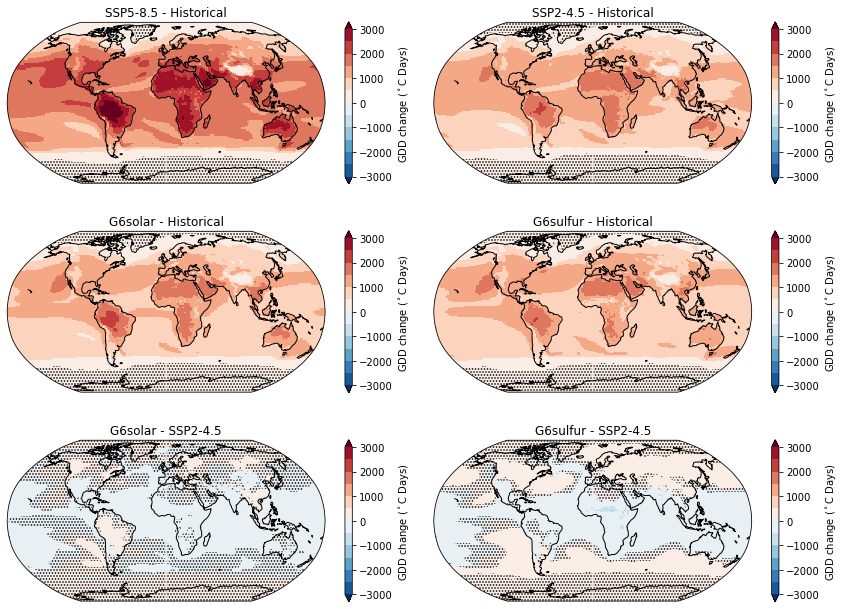

In [5]:
fig = plt.figure(figsize=(12,9)) # This sets the size of the figure (12 x 9), and hence the space 
# between figures when it tries to fit them in to the figure space. You'll need to change this if you have a different
# Number of rows / columns
cbar_label = 'GDD change ($^\circ$C Days)'
cbar_shrink = 0.8 # 80% of standard size
title_size = 12
cmap = 'RdBu_r' # a full list of colormaps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# FYI adding '_r' on the end reverses the order, useful if you find one that would look better the other way around
# If we didn't have the 2 bottom panels with their negative values then a one-sided colorscale like 'BuGn' could work.
color_min = -3000 
color_max = 3000.
levels = 13 # 6 + 6 + 1, which works as 6*500 = 3000, you want the intervals to land on round numbers
extend = 'both'
# Note, where the plot exceeds a limit it will add an extension as in the top-left plot.
# You can also manually specify the levels by entering a list instead of '15' for levels.
# Note, if "levels = None" then you will get a continuous colorscale but this makes it harder to read. pros and cons.

"""
First plot ssp5-85 anomaly
"""
# Change this stuff per panel
plot_title = 'SSP5-8.5 - Historical'
plot_data = ssp585_anom[var]
plot_ttest = ssp585_anom_ttest
position = 1

# Leave this stuff per panel (unless changing functionality)
# Create a multi-panel plot and This plot goes into the first position, counting top-left to bottom right.
# The code: (2, 2, 1) = (2 columns, 3 rows, position 1)
ax1 = plt.subplot(3, 2, position, projection=ccrs.Robinson())
ax1.coastlines()
plot_data.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=plt.get_cmap(cmap), levels = levels, vmin=color_min, vmax=color_max, extend=extend, cbar_kwargs={'label':cbar_label, 'shrink': cbar_shrink})
plotted = plot_ttest.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=[0,p_thresh], hatches=["....",""], alpha=0, add_colorbar=False) # cbar_kwargs={'shrink': 0.0})
ax1.set_title(plot_title, fontsize=title_size)

"""
Second plot ssp2-45 anomaly
"""
plot_title = 'SSP2-4.5 - Historical'
plot_data = ssp245_anom[var]
plot_ttest = ssp245_anom_ttest
position = 2

ax1 = plt.subplot(3, 2, position, projection=ccrs.Robinson())
ax1.coastlines()
plot_data.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=plt.get_cmap(cmap), levels = levels, vmin=color_min, vmax=color_max, extend=extend, cbar_kwargs={'label':cbar_label, 'shrink': cbar_shrink})
plotted = plot_ttest.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=[0,p_thresh], hatches=["....",""], alpha=0, add_colorbar=False) # cbar_kwargs={'shrink': 0.0})
ax1.set_title(plot_title, fontsize=title_size)

"""
Third plot G6solar anomaly
"""
plot_title = 'G6solar - Historical'
plot_data = G6solar_anom[var]
plot_ttest = G6solar_anom_ttest
position = 3

ax1 = plt.subplot(3, 2, position, projection=ccrs.Robinson())
ax1.coastlines()
plot_data.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=plt.get_cmap(cmap), levels = levels, vmin=color_min, vmax=color_max, extend=extend, cbar_kwargs={'label':cbar_label, 'shrink': cbar_shrink})
plotted = plot_ttest.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=[0,p_thresh], hatches=["....",""], alpha=0, add_colorbar=False) # cbar_kwargs={'shrink': 0.0})
ax1.set_title(plot_title, fontsize=title_size)

"""
Fourth plot G6sulfur anomaly
"""
plot_title = 'G6sulfur - Historical'
plot_data = G6sulfur_anom[var]
plot_ttest = G6sulfur_anom_ttest
position = 4

ax1 = plt.subplot(3, 2, position, projection=ccrs.Robinson())
ax1.coastlines()
plot_data.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=plt.get_cmap(cmap), levels = levels, vmin=color_min, vmax=color_max, extend=extend, cbar_kwargs={'label':cbar_label, 'shrink': cbar_shrink})
plotted = plot_ttest.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=[0,p_thresh], hatches=["....",""], alpha=0, add_colorbar=False) # cbar_kwargs={'shrink': 0.0})
ax1.set_title(plot_title, fontsize=title_size)

"""
Fifth plot G6solar - SSP2-45 anomaly
"""
plot_title = 'G6solar - SSP2-4.5'
plot_data = G6solar_45_anom[var]
plot_ttest = G6solar_45_anom_ttest
position = 5

ax1 = plt.subplot(3, 2, position, projection=ccrs.Robinson())
ax1.coastlines()
plot_data.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=plt.get_cmap(cmap), levels = levels, vmin=color_min, vmax=color_max, extend=extend, cbar_kwargs={'label':cbar_label, 'shrink': cbar_shrink})
plotted = plot_ttest.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=[0,p_thresh], hatches=["....",""], alpha=0, add_colorbar=False) # cbar_kwargs={'shrink': 0.0})
ax1.set_title(plot_title, fontsize=title_size)

"""
Sixth plot G6sulfur - SSP2-45 anomaly
"""
plot_title = 'G6sulfur - SSP2-4.5'
plot_data = G6sulfur_45_anom[var]
plot_ttest = G6sulfur_45_anom_ttest
position = 6

ax1 = plt.subplot(3, 2, position, projection=ccrs.Robinson())
ax1.coastlines()
plot_data.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=plt.get_cmap(cmap), levels = levels, vmin=color_min, vmax=color_max, extend=extend, cbar_kwargs={'label':cbar_label, 'shrink': cbar_shrink})
plotted = plot_ttest.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=[0,p_thresh], hatches=["....",""], alpha=0, add_colorbar=False) # cbar_kwargs={'shrink': 0.0})
ax1.set_title(plot_title, fontsize=title_size)

fig.tight_layout()

plt.savefig('plots/'+var+'_full_figure_example.png') # You'll need to make a plots directory if you copy this!

# DRAFT cf-plot version

In [6]:
"""
Convert the means and standard deviations datasets to numpy arrays
"""

historical_mean_np, historical_std_np = historical_mean[var].values, historical_std[var].values
ssp245_mean_np, ssp245_std_np = ssp245_mean[var].values, ssp245_std[var].values
ssp585_mean_np, ssp585_std_np = ssp585_mean[var].values, ssp585_std[var].values
G6solar_mean_np, G6solar_std_np = G6solar_mean[var].values, G6solar_std[var].values
G6sulfur_mean_np, G6sulfur_std_np = G6sulfur_mean[var].values, G6sulfur_std[var].values

# We also need to extract the lons and lats as we're no longer working with the datasets that include them.
lons = ssp245_mean.lon.values
lats = ssp245_mean.lat.values

# reCalculate the anomalies as numpy arrays - NOTE I've now replaced the anomalies defined above:
ssp245_anom = ssp245_mean_np - historical_mean_np
ssp585_anom = ssp585_mean_np - historical_mean_np
G6sulfur_anom = G6sulfur_mean_np - historical_mean_np
G6solar_anom = G6solar_mean_np - historical_mean_np
G6sulfur_45_anom = G6sulfur_mean_np - ssp245_mean_np
G6solar_45_anom = G6solar_mean_np - ssp245_mean_np

"""
Calculate the T-test results
"""

# Note, I'm using ttest_sub which is called inside ttest_func
ssp245_anom_ttest_np = p_thresh > ttest_sub(ssp245_mean_np,ssp245_std_np,num_years,historical_mean_np,historical_std_np,num_years)
ssp585_anom_ttest_np = p_thresh > ttest_sub(ssp585_mean_np,ssp585_std_np,num_years,historical_mean_np,historical_std_np,num_years)
G6solar_anom_ttest_np = p_thresh > ttest_sub(G6solar_mean_np,G6solar_std_np,num_years,historical_mean_np,historical_std_np,num_years)
G6sulfur_anom_ttest_np = p_thresh > ttest_sub(G6sulfur_mean_np,G6sulfur_std_np,num_years,historical_mean_np,historical_std_np,num_years)
G6solar_anom_ttest_np = p_thresh > ttest_sub(G6solar_mean_np,G6solar_std_np,num_years,ssp245_mean_np,ssp245_std_np,num_years)
G6sulfur_anom_ttest_np = p_thresh > ttest_sub(G6sulfur_mean_np,G6sulfur_std_np,num_years,ssp245_mean_np,ssp245_std_np,num_years)

"""
Some useful alternative anomalies, which are much simpler to calculate with numpy arrays
"""

# percentage anomaly
ssp245_pc_anom_np = 100. * (ssp245_mean_np - historical_mean_np) / historical_mean_np

# anomaly normalized by control standard deviations (tells you how large your signal is relative to noise)
ssp245_SD_anom_np = (ssp245_mean_np - historical_mean_np) / historical_std_np

"""
Note, this will throw some warnings as we're dividing by zero in some places.
These alternatives are best used on data that doesn't have zero values.
"""

<ipython-input-6-cf12d48593b6>:40: RuntimeWarning: divide by zero encountered in true_divide
  ssp245_pc_anom_np = 100. * (ssp245_mean_np - historical_mean_np) / historical_mean_np

<ipython-input-6-cf12d48593b6>:40: RuntimeWarning: invalid value encountered in true_divide
  ssp245_pc_anom_np = 100. * (ssp245_mean_np - historical_mean_np) / historical_mean_np

<ipython-input-6-cf12d48593b6>:43: RuntimeWarning: divide by zero encountered in true_divide
  ssp245_SD_anom_np = (ssp245_mean_np - historical_mean_np) / historical_std_np

<ipython-input-6-cf12d48593b6>:43: RuntimeWarning: invalid value encountered in true_divide
  ssp245_SD_anom_np = (ssp245_mean_np - historical_mean_np) / historical_std_np



"\nNote, this will throw some warnings as we're dividing by zero in some places.\nThese alternatives are best used on data that doesn't have zero values.\n"

# Draft - needs T-Test and colorbar fix.

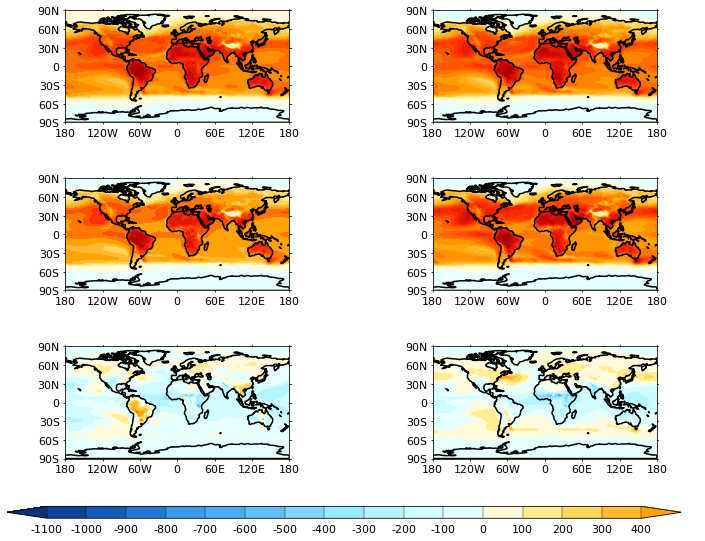

In [7]:
cfp.gopen(rows=3, columns=2, bottom=0.2)
# cfp.gpos(1)
cfp.con(f=ssp585_anom, x=lons, y=lats, ptype=1, lines=False, colorbar=None)
cfp.gpos(2)
cfp.con(f=ssp245_anom, x=lons, y=lats, ptype=1, lines=False, colorbar=None)
cfp.gpos(3)
cfp.con(f=G6solar_anom, x=lons, y=lats, ptype=1, lines=False, colorbar=None)
cfp.gpos(4)
cfp.con(f=G6sulfur_anom, x=lons, y=lats, ptype=1, lines=False, colorbar=None)
cfp.gpos(5)
cfp.con(f=G6solar_45_anom, x=lons, y=lats, ptype=1, lines=False, colorbar=None)
cfp.gpos(6)
cfp.con(f=G6sulfur_45_anom, x=lons, y=lats, ptype=1, lines=False, colorbar_position=[0.1, 0.1, 0.8, 0.02],
        colorbar_orientation='horizontal')
cfp.gclose()